# Differential correlation for canonical and non-canonical ISGs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
# from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
import scipy.sparse as sparse

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [4]:
data_path = '/home/ubuntu/Data/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Association between DE and DC

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

/home/ubuntu/anaconda3/envs/cellxgene/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [8]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [9]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

In [10]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [11]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [12]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

In [13]:
ct = ['C']


In [14]:
with open('canonical_isgs.pkl', 'rb') as f:
    canonical_genes = pkl.load(f)
with open('noncanonical_isgs.pkl', 'rb') as f:
    noncanonical_genes = pkl.load(f)

In [15]:
adata_tp = adata.copy()[
    adata.obs.time.isin(['0', '6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta', 'control'])].copy()
adata_tp.obs['tp'] = adata_tp.obs['time'].apply(lambda x: {'0':0, '6':1}[x])

memento.create_groups(adata_tp, label_columns=['donor', 'tp'])
memento.compute_1d_moments(adata_tp, min_perc_group=.9)

meta_df = memento.get_groups(adata_tp)
treatment = meta_df[['tp']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

/home/ubuntu/Github/scrna-parameter-estimation/memento/main.py:181: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [16]:
memento.ht_1d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=14,
        resample_rep=False,
        approx=stats.norm)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.6s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    6.8s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   12.7s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   20.6s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   29.9s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   41.6s
[Parallel(n_jobs=14)]: Done 2422 tasks      | elapsed:   55.5s
[Parallel(n_jobs=14)]: Done 3172 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  1.5min
[Parallel(n_jobs=14)]: Done 4972 tasks      | elapsed:  1.8min
[Parallel(n_jobs=14)]: Done 6022 tasks      | elapsed:  2.2min
[Parallel(n_jobs=14)]: Done 7172 tasks      | elapsed:  2.6min
[Parallel(n_jobs=14)]: Done 8422 tasks      | elapsed:  3.1min
[Parallel(n_jobs=14)]: Done 9679 out of 9679 | elapsed:  3.5min finished


In [17]:
memento.compute_2d_moments(adata_tp, list(zip(np.random.choice(adata_tp.var.index, 5000), np.random.choice(adata_tp.var.index, 5000))))

memento.ht_2d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=5000, 
        verbose=1,
        num_cpus=14,
        resample_rep=False,
        approx='boot')
random_result = memento.get_2d_ht_result(adata_tp)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.7s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    4.8s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   11.2s
/home/ubuntu/Github/scrna-parameter-estimation/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/ubuntu/Github/scrna-parameter-estimation/memento/hypothesis_test.py:99: RuntimeWarning: invalid value encountered in scalar divide
  return (extreme_count) / (null.shape[0])
/home/ubuntu/anaconda3/envs/cellxgene/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   20.3s
/home/ubuntu/Github/scrna-parameter-estimation/memento/hypothes

In [18]:
de_result = memento.get_1d_ht_result(adata_tp)

In [19]:
merged = random_result\
    .merge(de_result[['gene', 'de_coef']].rename(columns={'gene':'gene_1'}), on='gene_1')\
    .merge(de_result[['gene', 'de_coef']].rename(columns={'gene':'gene_2'}), on='gene_2')

In [20]:
merged

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,de_coef_x,de_coef_y
0,CTCF,C1orf131,tp,-0.200174,0.317138,0.5192,-0.123091,0.121855
1,TNFRSF19,RAPGEF2,tp,-0.368415,0.304538,0.2444,0.012788,0.011365
2,PCNX3,CTU1,tp,0.013791,0.388397,0.9700,0.095856,0.114329
3,ATP5F1C,CHPF,tp,0.096637,0.226685,0.6686,-0.165814,-0.023476
4,TEKT1,MGRN1,tp,-0.146159,0.225613,0.5122,-0.203851,0.326289
...,...,...,...,...,...,...,...,...
4995,MAML1,TBL1X,tp,0.216129,0.239225,0.3620,0.536897,-0.156461
4996,POLR1D,RAD21,tp,0.355895,0.183548,0.0568,-0.128164,-0.155060
4997,REC8,GTF3C1,tp,0.089864,0.136868,0.4910,0.209940,-0.313815
4998,JMY,ARPC1B,tp,NaN,NaN,NaN,-0.233342,-0.595480


In [21]:
r_5k, _ = stats.pearsonr(merged.dropna()['de_coef_x']+merged.dropna()['de_coef_y'], merged.dropna()['corr_coef'])

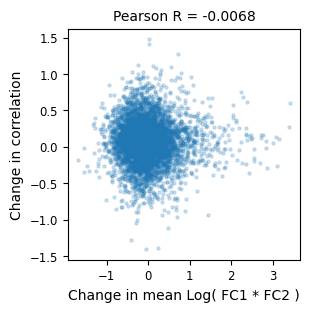

In [22]:
plt.figure(figsize=(3,3))
plt.scatter(merged['de_coef_y'] + merged['de_coef_x'], merged['corr_coef'], s=5, alpha=0.2)
plt.xlabel('Change in mean Log( FC1 * FC2 )')
plt.ylabel('Change in correlation');
plt.title('Pearson R = {:.4f}'.format(r_5k))
plt.savefig('mean_vs_corr.png', dpi=300, bbox_inches='tight')

In [ ]:
merged.to_csv('de_dc_association.csv')

### Filter by combined LFC genes

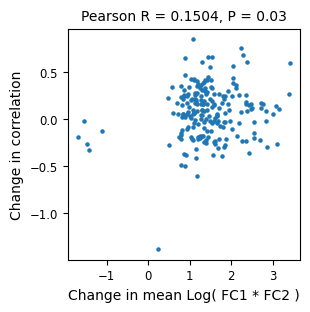

In [39]:
de_merged = merged.copy()
de_merged['FC_combined'] = de_merged['de_coef_x'] + de_merged['de_coef_y']
# de_merged = de_merged.query('FC_combined > 1 | FC_combined < -1')
de_merged = de_merged.query('de_coef_x > 1 | de_coef_y > 1 | de_coef_x < -1 | de_coef_y < -1')
r_de, pv_de = stats.pearsonr(de_merged.dropna()['de_coef_x']+de_merged.dropna()['de_coef_y'], de_merged.dropna()['corr_coef'])
plt.figure(figsize=(3,3))
plt.scatter(de_merged['FC_combined'], de_merged['corr_coef'], s=5)
plt.title('Pearson R = {:.4f}, P = {:.2f}'.format(r_de, pv_de))
plt.xlabel('Change in mean Log( FC1 * FC2 )')
plt.ylabel('Change in correlation');
plt.savefig('mean_vs_corr_de.png', dpi=300, bbox_inches='tight')

# Do the same after shuffling the columns

Restart kernel here, shared variables (same imports)

In [8]:
from sklearn.utils import shuffle

In [9]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

/home/ubuntu/anaconda3/envs/cellxgene/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [10]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [11]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

In [12]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [13]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [14]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

In [15]:
ct = ['C']


In [16]:
with open('canonical_isgs.pkl', 'rb') as f:
    canonical_genes = pkl.load(f)
with open('noncanonical_isgs.pkl', 'rb') as f:
    noncanonical_genes = pkl.load(f)

In [17]:
adata_tp = adata.copy()[
    adata.obs.time.isin(['0', '6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta', 'control'])].copy()
adata_tp.obs['tp'] = adata_tp.obs['time'].apply(lambda x: {'0':0, '6':1}[x])

In [18]:
donors = adata_tp.obs.donor.drop_duplicates().tolist()
conditions = ['beta', 'control']

In [19]:
expr_matrix_dense = adata_tp.X.toarray()
for cond in conditions:
    for donor in donors:
        donor_indices = ((adata_tp.obs['donor'] == donor) & (adata_tp.obs['stim']==cond)).values
        for col in range(expr_matrix_dense.shape[1]):
            expr_matrix_dense[donor_indices, col] = shuffle(expr_matrix_dense[donor_indices, col])
adata_tp.X = sparse.csr_matrix(expr_matrix_dense)

In [20]:
memento.create_groups(adata_tp, label_columns=['donor', 'tp'])
memento.compute_1d_moments(adata_tp, min_perc_group=.9)

meta_df = memento.get_groups(adata_tp)
treatment = meta_df[['tp']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

/home/ubuntu/Github/scrna-parameter-estimation/memento/main.py:181: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [21]:
memento.ht_1d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=1000, 
        verbose=1,
        num_cpus=14,
        resample_rep=False,
        approx=stats.norm)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    2.8s
[Parallel(n_jobs=14)]: Done 296 tasks      | elapsed:    3.9s
[Parallel(n_jobs=14)]: Done 1296 tasks      | elapsed:    6.9s
[Parallel(n_jobs=14)]: Done 2696 tasks      | elapsed:   10.8s
[Parallel(n_jobs=14)]: Done 4496 tasks      | elapsed:   15.9s
[Parallel(n_jobs=14)]: Done 6696 tasks      | elapsed:   22.2s
[Parallel(n_jobs=14)]: Done 9296 tasks      | elapsed:   29.6s
[Parallel(n_jobs=14)]: Done 9866 out of 9866 | elapsed:   31.5s finished


In [22]:
memento.compute_2d_moments(adata_tp, list(zip(np.random.choice(adata_tp.var.index, 5000), np.random.choice(adata_tp.var.index, 5000))))

memento.ht_2d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=1000, 
        verbose=1,
        num_cpus=14,
        resample_rep=False,
        approx='boot')
random_result = memento.get_2d_ht_result(adata_tp)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 548 tasks      | elapsed:    3.0s
/home/ubuntu/Github/scrna-parameter-estimation/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/ubuntu/Github/scrna-parameter-estimation/memento/hypothesis_test.py:99: RuntimeWarning: invalid value encountered in scalar divide
  return (extreme_count) / (null.shape[0])
/home/ubuntu/anaconda3/envs/cellxgene/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[Parallel(n_jobs=14)]: Done 1548 tasks      | elapsed:    8.5s
[Parallel(n_jobs=14)]: Done 2948 tasks      | elapsed:   15.9s
[Parallel(n_jobs=14)]: Done 4748 tasks      | elapsed:   25.5

In [25]:
de_result = memento.get_1d_ht_result(adata_tp)

In [26]:
merged = random_result\
    .merge(de_result[['gene', 'de_coef']].rename(columns={'gene':'gene_1'}), on='gene_1')\
    .merge(de_result[['gene', 'de_coef']].rename(columns={'gene':'gene_2'}), on='gene_2')

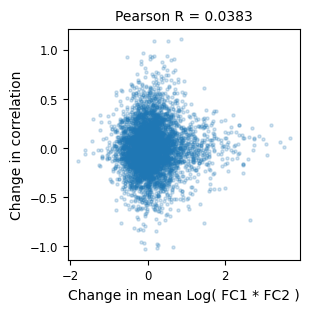

In [27]:
plt.figure(figsize=(3,3))
plt.scatter(merged['de_coef_y'] + merged['de_coef_x'], merged['corr_coef'], s=5, alpha=0.2)
plt.xlabel('Change in mean Log( FC1 * FC2 )')
plt.ylabel('Change in correlation');
r_5k, _ = stats.pearsonr(merged.dropna()['de_coef_x']+merged.dropna()['de_coef_y'], merged.dropna()['corr_coef'])
plt.title('Pearson R = {:.4f}'.format(r_5k))
plt.savefig('shuffled_mean_vs_corr.png', dpi=300, bbox_inches='tight')

In [ ]:
merged.to_csv('shuffled_de_dc_association.csv')

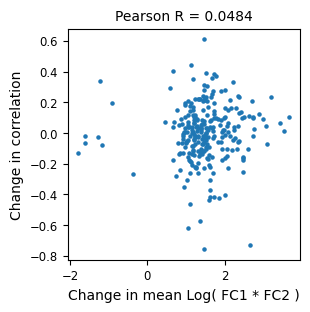

In [30]:
de_merged = merged.copy()
de_merged['FC_combined'] = de_merged['de_coef_x'] + de_merged['de_coef_y']
de_merged = de_merged.query('de_coef_x > 1 | de_coef_y > 1 | de_coef_x < -1 | de_coef_y < -1')

r_de, _ = stats.pearsonr(de_merged.dropna()['de_coef_x']+de_merged.dropna()['de_coef_y'], de_merged.dropna()['corr_coef'])

plt.figure(figsize=(3,3))
plt.scatter(de_merged['FC_combined'], de_merged['corr_coef'], s=5)
plt.title('Pearson R = {:.4f}'.format(r_de))
plt.xlabel('Change in mean Log( FC1 * FC2 )')
plt.ylabel('Change in correlation');
plt.savefig('shuffled_mean_vs_corr_de.png', dpi=300, bbox_inches='tight')